## Bechmark modelling - Linear models

The purpose of this file is to create model benchmarks which we will compare against the final optimized fits, this ensures we can  
check whether the optimization was successful and signifficant as well as changes in attribute weights (e.g. regression analysis)

The second part of the file is to perform regression analysis utilizing the benchmark models to determine the biggest contributors (attributes)  
to the target attribute = popularity.

In [1]:
import os
import sys

sys.dont_write_bytecode = True

import numpy as np
import pandas as pd

from dotenv import load_dotenv
load_dotenv()

False

In [2]:
from etl import *

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error

loading data

In [12]:
DATA_DIR = './Data/'
DATA_FILE = 'spotify_tracks_kaggle_weekly.csv'

In [13]:
data = pd.read_csv(DATA_DIR + DATA_FILE)

data split on predefined conditions

In [20]:
RANDOM_STATE = 21
TEST_SIZE = 0.1

In [21]:
X = data.drop('popularity', axis=1)
y = data['popularity']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

### Testing scenario

We will compare the transformation pipeline results against the basic dataset form, to determine the utility of the transformations.  
It is important to state that the overall benefit of transformation pipeline could be present after the optimization - that means the verdict of the effectiveness  
is valid only for the benchmark linear fits.

#### 1. Original data - Nulls are not processed, original encoding, not-scaled

In [123]:
models_1 = {
    'linear_regression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso()
}

In [124]:
drop_columns = ['track_id', 'artwork_url', 'track_url',
                 'track_name', 'album_name', 'artist_name', 'language']

In [125]:
X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

In [126]:
for model_name, model in models_1.items():
    model.fit(X_train, y_train)
    print(f"fitting {model_name:<20} ... train R^2 = {model.score(X_train, y_train):.5f}")

fitting linear_regression    ... train R^2 = 0.05611
fitting Ridge                ... train R^2 = 0.05611
fitting Lasso                ... train R^2 = 0.00268


prediction

In [127]:
for model_name, model in models_1.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    print(f"Model: {model_name:<20} ... test R^2 = {model.score(X_test, y_test):.5f} | MSE: {mse:.5f} | RMSE: {rmse:.5f}")

Model: linear_regression    ... test R^2 = 0.05155 | MSE: 338.23823 | RMSE: 18.39125
Model: Ridge                ... test R^2 = 0.05156 | MSE: 338.23771 | RMSE: 18.39124
Model: Lasso                ... test R^2 = 0.00247 | MSE: 355.74171 | RMSE: 18.86112


#### 2. Transformed data - includes custom encoding, scaling, ...

In [128]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

drop_columns = ['track_id', 'artwork_url', 'track_url', 'track_name', 'album_name']

X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

In [129]:
target = 'popularity'

onehot_col = ['language']
circle_of_fifths_col = ['key']
artist_name_col = ['artist_name']

numeric_columns = list(X_train.columns[X_train.dtypes != object].difference(['key', 'mode']))

nan_columns = ['acousticness', 'danceability', 'energy', 'liveness', 'speechiness', 'tempo', 'valence']

In [130]:
numeric_pipeline = Pipeline(steps=[
    ('scaling', StandardScaler())
])

artist_name_pipeline = Pipeline(steps=[
    ('encoding', FrequencyEncoder()),
    ('scaling', StandardScaler())
])


transformations = ColumnTransformer(transformers=[
    
    ('onehot_encoding', OneHotEncoder(sparse_output=False), onehot_col),
    ('trigonometric_encoding', CircleOfFifthsEncoding(), circle_of_fifths_col),
    ('artist_encoding', artist_name_pipeline, artist_name_col),
    ('nummeric_processing', numeric_pipeline, numeric_columns)

], remainder='drop')


preprocessing = Pipeline(steps=[
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations)
])

In [131]:
preprocessing.fit(X_train)

Pipeline(steps=[('null_values',
                 ConvertNull(columns=['acousticness', 'danceability', 'energy',
                                      'liveness', 'speechiness', 'tempo',
                                      'valence'])),
                ('transformation',
                 ColumnTransformer(transformers=[('onehot_encoding',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['language']),
                                                 ('trigonometric_encoding',
                                                  CircleOfFifthsEncoding(),
                                                  ['key']),
                                                 ('artist_encoding',
                                                  Pipeline(steps=[('encoding',
                                                                   FrequencyEncoder()),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['artist_name']),
                                                 ('nummeric_processing',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'time_signature', 'valence',
                                                   'year'])]))])

In [132]:
X_train_transformed = preprocessing.transform(X_train)
X_test_transformed = preprocessing.transform(X_test)

Nulls dropped

In [133]:
X_train_transformed = pd.DataFrame(X_train_transformed).dropna()
X_test_transformed = pd.DataFrame(X_test_transformed).dropna()

y_train_transformed = y_train.reset_index(drop=True).loc[X_train_transformed.index]
y_test_transformed = y_test.reset_index(drop=True).loc[X_test_transformed.index]

In [135]:
models_2 = {
    'linear_regression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso()
}

In [136]:
for model_name, model in models_2.items():
    model.fit(X_train_transformed, y_train_transformed)
    print(f"fitting {model_name:<20} ... train R^2 = {model.score(X_train_transformed, y_train_transformed):.5f}")

print()
print()

for model_name, model in models_2.items():
    y_pred = model.predict(X_test_transformed)
    mse = mean_squared_error(y_test_transformed, y_pred)
    rmse = root_mean_squared_error(y_test_transformed, y_pred)

    print(f"Model: {model_name:<20} ... test R^2 = {model.score(X_test_transformed, y_test_transformed):.5f} | MSE: {mse:.5f} | RMSE: {rmse:.5f}")

fitting linear_regression    ... train R^2 = 0.11218
fitting Ridge                ... train R^2 = 0.10617
fitting Lasso                ... train R^2 = 0.04652


Model: linear_regression    ... test R^2 = 0.11385 | MSE: 316.11583 | RMSE: 17.77965
Model: Ridge                ... test R^2 = 0.10924 | MSE: 317.76089 | RMSE: 17.82585
Model: Lasso                ... test R^2 = 0.04721 | MSE: 339.88902 | RMSE: 18.43608


Verdict: Transformation pipeline doubled the quality of the fit from 5% --> 10%

### Benchmark models on enhanced pipeline - new base features + polynomial features

In [8]:
DATA_DIR = './Data/'
DATA_FILE = 'spotify_tracks_kaggle_weekly.csv'
ARTIST_FILE = 'spotify_tracks_artist_details.csv'

RANDOM_STATE = 21
TEST_SIZE = 0.1

In [7]:
data_tracks = pd.read_csv(DATA_DIR + DATA_FILE)
data_artist = pd.read_csv(DATA_DIR + ARTIST_FILE)

data = pd.merge(data_tracks, data_artist, on='track_id', how='left')

In [10]:
X = data.drop('popularity', axis=1)
y = data['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [11]:
drop_columns = ['track_id', 'artwork_url', 'track_url', 'track_name']

X_train = X_train.drop(drop_columns, axis=1, errors='ignore')
X_test = X_test.drop(drop_columns, axis=1, errors='ignore')

In [12]:
target = 'popularity'

onehot_col = ['language']
circle_of_fifths_col = ['key']
artist_name_col = ['artist_name']
album_name_col = ['album_name']

numeric_columns = list(X_train.columns[X_train.dtypes != object].difference(['key', 'mode']))

nan_columns = ['acousticness', 'danceability', 'energy', 'liveness', 'speechiness', 'tempo', 'valence']

In [22]:
numeric_pipeline = Pipeline(steps=[
    ('imputation', SimpleImputer()),
    ('polynomials', PolynomialFeatures()),
    ('scaling', StandardScaler())
])

artist_name_pipeline = Pipeline(steps=[
    ('encoding', FrequencyEncoder()),
    ('imputation', SimpleImputer()),
    ('scaling', StandardScaler())
])

album_name_pipeline = Pipeline(steps=[
    ('encoding', AlbumNameEncoder()),
    ('imputation', SimpleImputer())
])

circle_of_fifths_pipeline = Pipeline(steps=[
    ('encoding', CircleOfFifthsEncoding()),
    ('imputation', SimpleImputer())
])


transformations = ColumnTransformer(transformers=[
    
    ('onehot_encoding', OneHotEncoder(sparse_output=False), onehot_col),
    ('trigonometric_encoding', circle_of_fifths_pipeline, circle_of_fifths_col),
    ('artist_encoding', artist_name_pipeline, artist_name_col),
    ('album_encoding', album_name_pipeline, album_name_col),
    ('nummeric_processing', numeric_pipeline, numeric_columns)

], remainder='drop').set_output(transform='pandas')


preprocessing = Pipeline(steps=[
    
    ('null_values', ConvertNull(columns=nan_columns)),
    ('transformation', transformations)

]).set_output(transform='pandas')

linear models benchmark fit - optimized pipeline

In [23]:
models = {
    'linear_regression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso()
}

In [24]:
for model_name, model in models.items():
    
    model_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing),
        ('model', model)
    ])

    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"fitting {model_name:<20} ... train R^2 = {model_pipeline.score(X_train, y_train):.5f}")
    print(f"Model: {model_name:<20} ... test R^2 = {model_pipeline.score(X_test, y_test):.5f} | MSE: {mse:.5f} | RMSE: {rmse:.5f}")

    print()


fitting linear_regression    ... train R^2 = 0.27227
Model: linear_regression    ... test R^2 = 0.26790 | MSE: 261.08458 | RMSE: 16.15811

fitting Ridge                ... train R^2 = 0.26387
Model: Ridge                ... test R^2 = 0.25966 | MSE: 264.02393 | RMSE: 16.24881

fitting Lasso                ... train R^2 = 0.17519
Model: Lasso                ... test R^2 = 0.17088 | MSE: 295.68521 | RMSE: 17.19550



### Regression analysis - interpretation of feature importance

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [47]:
columns = preprocessing.transform(X_train).columns

weights = {
    model_name : [
        (column, coef) for column, coef in zip(columns, model.coef_)
    ]

    for model_name, model in models.items()
}

results = {
    model_name : pd.DataFrame(weights[model_name], columns=['attribute', 'weight']) for model_name in models.keys()
}

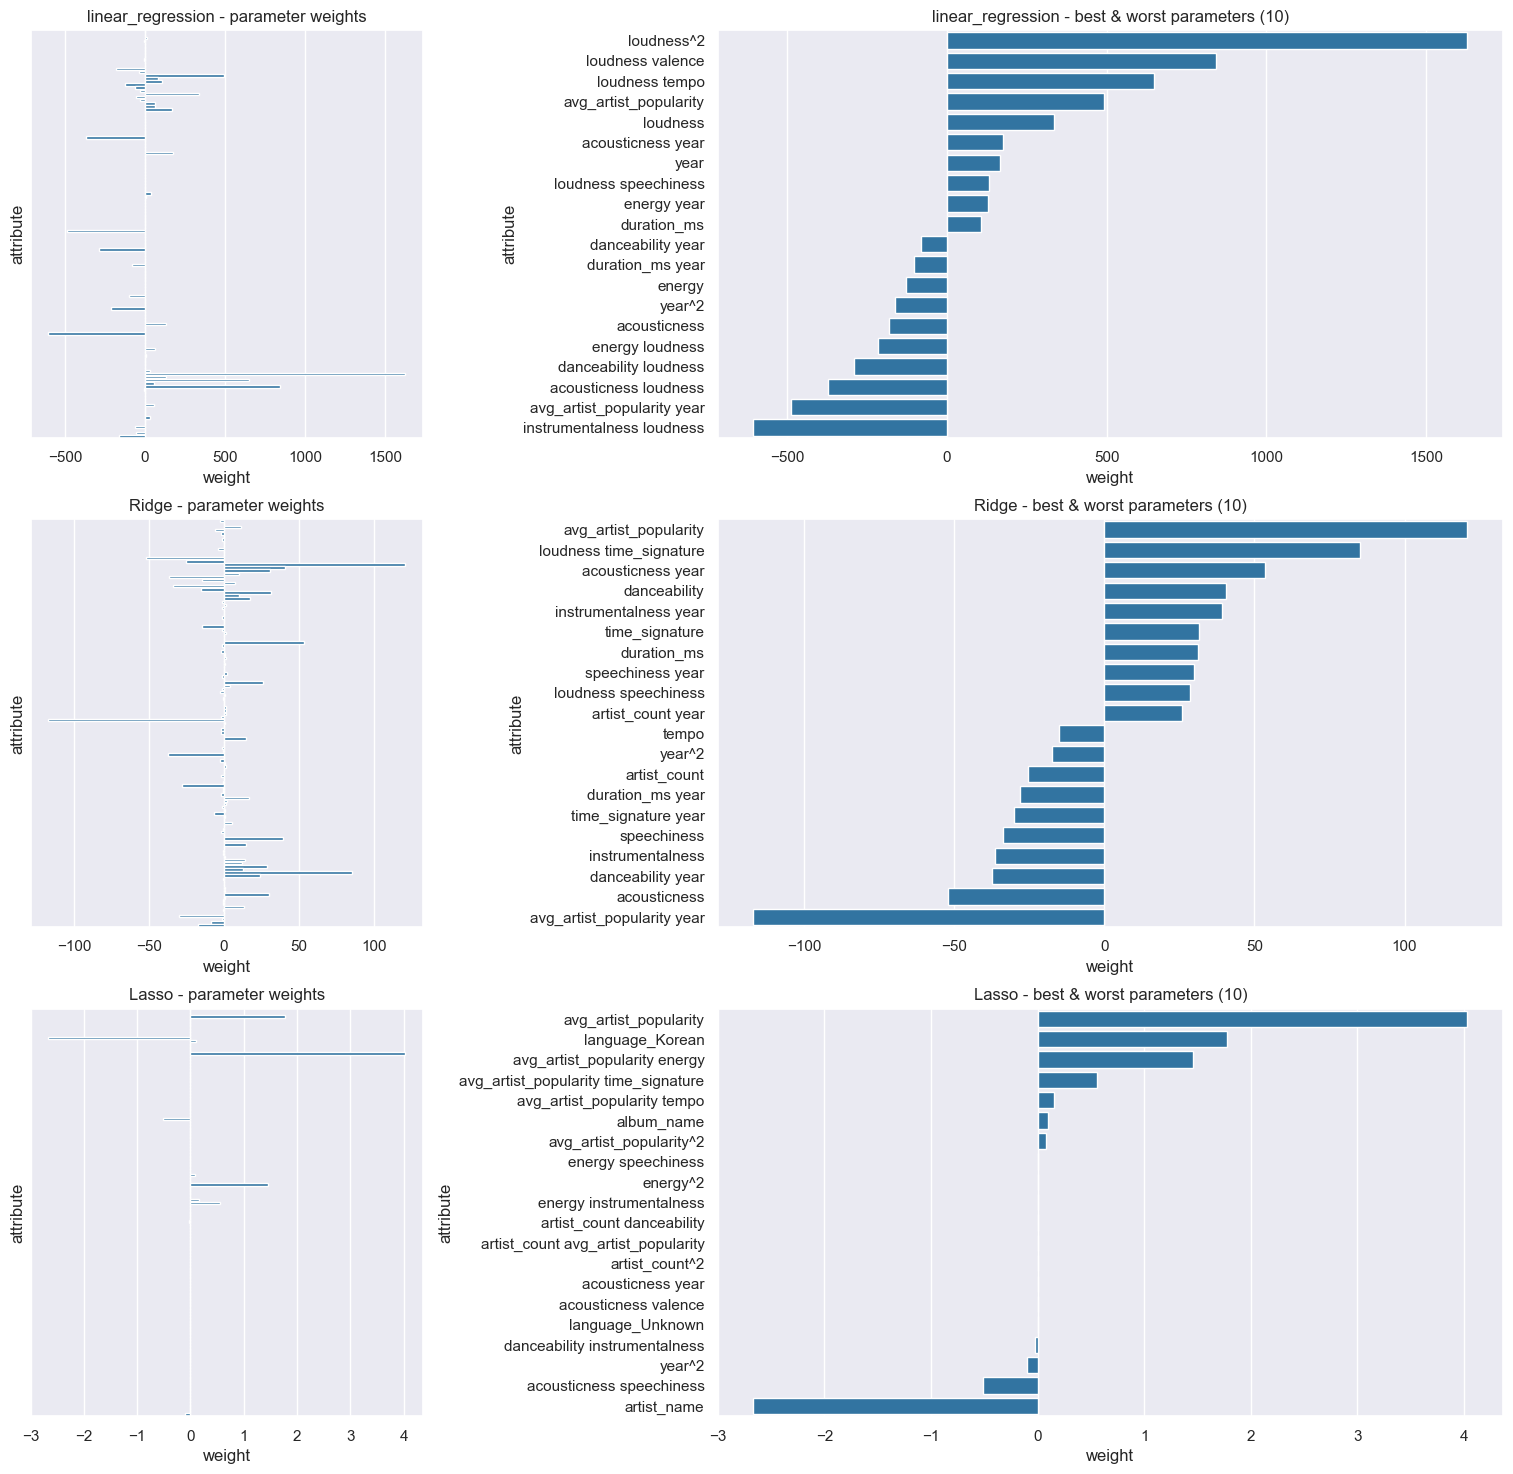

In [87]:
fig, axs = plt.subplots(3, 2, figsize=(19, 18), gridspec_kw={'width_ratios' : [1, 2], 'wspace' : 0.5})

model_names = list(models.keys())

for i, axes in enumerate(axs):

    axs[i][0].set_title(f"{model_names[i]} - parameter weights")
    axs[i][1].set_title(f"{model_names[i]} - best & worst parameters (10)")

    sns.barplot(data=results[model_names[i]], x='weight', y='attribute', ax=axs[i][0], color='tab:blue')

    n = 10

    subset = results[model_names[i]].sort_values(by='weight', ascending=False)
    target = pd.concat([subset.head(n), subset.tail(n)])

    target['attribute'] = target['attribute'].str.split('__').str[1]

    sns.barplot(data=target, x='weight', y='attribute', ax=axs[i][1], color='tab:blue')

    axs[i][0].set_yticks([])